# Christoffel symbols

$$\Gamma^i_{kl} = \frac{1}{2} g^{im} \left(g_{mk, l} + g_{ml, k} - g_{kl, m}\right)$$

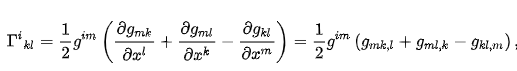

In [104]:
from operator import add 
from functools import reduce
from sympy import simplify

def metric_tensor_ij(surface_vector, coords, i, j):
    coord_i=coords[i]
    coord_j=coords[j]
    
    def diff_k_map(coord): 
        diff_expr = lambda el: el.diff(coord)
        return map(diff_expr, surface_vector)
    
    f_i = diff_k_map(coord_i)
    f_j = diff_k_map(coord_j)
    
    zip_fi_fj=zip(f_i, f_j)
    zip_mul=map(lambda x: x[0]*x[1], zip_fi_fj)
    
    return simplify(reduce(add, zip_mul))

def metric_tensor(surface_vector, coords):
    from numpy import zeros
    
    n = len(coords)
    g = Matrix(zeros((n, n)))
    
    for i in range(n):
        for j in range(n):
            g[(i, j)] = metric_tensor_ij(surface_vector, coords, i, j)
    
    return g

def christoffel_i_jk(metric_tensor, metric_tensor_inv, coords, i, j, k):   
    g_shape = metric_tensor.shape
    
    if(len(g_shape) != 2):
        msg=f'A metric tensor is a 2-form with equal shape. Given dimensions ({g_shape})!'
        raise ValueError(msg)
    
    m, n = g_shape
    
    if(metric_tensor.det()==0):
        msg=f'We assume a regular metric tensor.'
        raise ValueError(msg)
    
    is_out_bounds_map=lambda index: index < 0 or index >= m
    are_indexes_out_of_bounds=is_out_bounds_map(i) or is_out_bounds_map(j) or is_out_bounds_map(k)
    
    if(are_indexes_out_of_bounds):
        condition_msg=f'Dimensions i, j, k are positive integers lesser than {m}.'
        given_msg=f'Given indexes ({i}, {j}, {k})'
        raise IndexError(f'{condition_msg} {given_msg}')
    
    gamma_i_jk = 0
    for l in range(n):
        g_inv_il = metric_tensor_inv[(i, l)]
        
        coords_j=coords[j]
        coords_k=coords[k]
        coords_l=coords[l]
        
        g_lj=metric_tensor[(l, j)]
        g_lk=metric_tensor[(l, k)]
        g_jk=metric_tensor[(j, k)]
        
        gamma_i_jk += g_inv_il*(g_lj.diff(coords_k) + g_lk.diff(coords_j) - g_jk.diff(coords_l))
    
    return simplify(gamma_i_jk)

def christoffel_symbols(metric_tensor_, coords):
    from numpy import zeros
    
    n = len(coords)
    
    Gamma = zeros((n, n, n), dtype=object)
    metric_tensor_inv=simplify(metric_tensor_.inv())
    
    for i in range(n):
        for j in range(n):
            for k in range(n):
                Gamma[i, j, k] = christoffel_i_jk(metric_tensor_, metric_tensor_inv, coords, i, j, k)
                
    return Gamma

In [105]:
from sympy import cos, sin, sqrt, Matrix, ZeroMatrix
import numpy as np
import sympy as sp
from sympy import zeros

# Define symbols
u, v = sp.symbols('u v')

# Ellipsoid parameters: Semi-major and semi-minor axes
a, b, c = sp.symbols('a b c', positive=True)

coords_ellipsoid=(u, v)

# Eccentricity squared
lambda_squared = 1 - (b**2 / a**2)
lambda_ = sqrt(1 - lambda_squared)

# Parametric equations for the ellipsoid
x = a * cos(u) * sin(v)
y = b * sin(u) * sin(v)
z = c * cos(v)

f = [x, y, z]

g_ellipsoid = metric_tensor(f, coords_ellipsoid)

g_ellipsoid

Matrix([
[       (a**2*sin(u)**2 + b**2*cos(u)**2)*sin(v)**2,                   (-a**2 + b**2)*(cos(2*u - 2*v) - cos(2*u + 2*v))/8],
[(-a**2 + b**2)*(cos(2*u - 2*v) - cos(2*u + 2*v))/8, a**2*cos(u)**2*cos(v)**2 + b**2*sin(u)**2*cos(v)**2 + c**2*sin(v)**2]])

In [18]:
from sympy import cos, sin, sqrt, Matrix, ZeroMatrix, symbols
import numpy as np

# Define symbols
r, u, v = symbols('r u v')

coords_sphere = (r, u, v)

# Parametric equations for the ellipsoid
x = r * cos(u) * sin(v)
y = r * sin(u) * sin(v)
z = r * cos(v)

f = [x, y, z]

g_sphere = metric_tensor(f, coords_sphere)
g_sphere

Matrix([
[1,              0,    0],
[0, r**2*sin(v)**2,    0],
[0,              0, r**2]])

In [19]:
from sympy import cos, sin, sqrt, Matrix, ZeroMatrix, symbols
import numpy as np

# Define symbols
u, v = symbols('u v')

coords_parabolic = (u, v)

# Parametric equations for the ellipsoid
x = u
y = v
z = u ** 2 + v ** 2

f = [x, y, z]

g_parabolic = metric_tensor(f, coords_parabolic)
print(g_parabolic)

christoffel_parabolic=christoffel_symbols(g_parabolic, coords_parabolic)
print(christoffel_parabolic)

Matrix([[4*u**2 + 1, 4*u*v], [4*u*v, 4*v**2 + 1]])
[[[8*u/(4*u**2 + 4*v**2 + 1) 0]
  [0 8*u/(4*u**2 + 4*v**2 + 1)]]

 [[8*v/(4*u**2 + 4*v**2 + 1) 0]
  [0 8*v/(4*u**2 + 4*v**2 + 1)]]]


In [21]:
from numpy import zeros

Gamma = christoffel_symbols(g_sphere, coords_sphere)

# Display the simplified Christoffel symbols with upper indices
print("Gamma^r_rr:", Gamma[0, 0, 0])
print("Gamma^r_ru:", Gamma[0, 0, 1])
print("Gamma^r_rv:", Gamma[0, 0, 2])
print("Gamma^r_ur:", Gamma[0, 1, 0])
print("Gamma^r_uu:", Gamma[0, 1, 1])
print("Gamma^r_uv:", Gamma[0, 1, 2])
print("Gamma^r_vr:", Gamma[0, 2, 0])
print("Gamma^r_vu:", Gamma[0, 2, 1])
print("Gamma^r_vv:", Gamma[0, 2, 2])

print("Gamma^u_rr:", Gamma[1, 0, 0])
print("Gamma^u_ru:", Gamma[1, 0, 1])
print("Gamma^u_rv:", Gamma[1, 0, 2])
print("Gamma^u_ur:", Gamma[1, 1, 0])
print("Gamma^u_uu:", Gamma[1, 1, 1])
print("Gamma^u_uv:", Gamma[1, 1, 2])
print("Gamma^u_vr:", Gamma[1, 2, 0])
print("Gamma^u_vu:", Gamma[1, 2, 1])
print("Gamma^u_vv:", Gamma[1, 2, 2])

print("Gamma^v_rr:", Gamma[2, 0, 0])
print("Gamma^v_ru:", Gamma[2, 0, 1])
print("Gamma^v_rv:", Gamma[2, 0, 2])
print("Gamma^v_ur:", Gamma[2, 1, 0])
print("Gamma^v_uu:", Gamma[2, 1, 1])
print("Gamma^v_uv:", Gamma[2, 1, 2])
print("Gamma^v_vr:", Gamma[2, 2, 0])
print("Gamma^v_vu:", Gamma[2, 2, 1])
print("Gamma^v_vv:", Gamma[2, 2, 2])

Gamma^r_rr: 0
Gamma^r_ru: 0
Gamma^r_rv: 0
Gamma^r_ur: 0
Gamma^r_uu: -2*r*sin(v)**2
Gamma^r_uv: 0
Gamma^r_vr: 0
Gamma^r_vu: 0
Gamma^r_vv: -2*r
Gamma^u_rr: 0
Gamma^u_ru: 2/r
Gamma^u_rv: 0
Gamma^u_ur: 2/r
Gamma^u_uu: 0
Gamma^u_uv: 2/tan(v)
Gamma^u_vr: 0
Gamma^u_vu: 2/tan(v)
Gamma^u_vv: 0
Gamma^v_rr: 0
Gamma^v_ru: 0
Gamma^v_rv: 2/r
Gamma^v_ur: 0
Gamma^v_uu: -sin(2*v)
Gamma^v_uv: 0
Gamma^v_vr: 2/r
Gamma^v_vu: 0
Gamma^v_vv: 0


In [23]:
from numpy import zeros

Gamma = christoffel_symbols(g_ellipsoid, coords_ellipsoid)

# Display the simplified Christoffel symbols with upper indices
print("Gamma^u_uu:", Gamma[0, 0, 0])
print("Gamma^u_uv:", Gamma[0, 0, 1])
print("Gamma^u_vu:", Gamma[0, 1, 0])
print("Gamma^u_vv:", Gamma[0, 1, 1])

print("Gamma^v_uu:", Gamma[1, 0, 0])
print("Gamma^v_uv:", Gamma[1, 0, 1])
print("Gamma^v_vu:", Gamma[1, 1, 0])
print("Gamma^v_vv:", Gamma[1, 1, 1])

Gamma^u_uu: c**2*(-3 + sin(3*v)/sin(v))*(a**2 - b**2)*sin(u)*cos(u)/(2*(a**2*b**2*sin(v)**2 - a**2*b**2 - a**2*c**2*sin(u)**2*sin(v)**2 + b**2*c**2*sin(u)**2*sin(v)**2 - b**2*c**2*sin(v)**2))
Gamma^u_uv: (-2*(a**2 - b**2)**2*(2*sin(2*v) + sin(4*u - 2*v) - sin(4*u + 2*v)) + 64*(a**2*sin(u)**2 + b**2*cos(u)**2)*(a**2*cos(u)**2*cos(v)**2 + b**2*sin(u)**2*cos(v)**2 + c**2*sin(v)**2)*tan(v))/(32*(-a**2*b**2*sin(v)**2 + a**2*b**2 + a**2*c**2*sin(u)**2*sin(v)**2 - b**2*c**2*sin(u)**2*sin(v)**2 + b**2*c**2*sin(v)**2)*tan(v)**2)
Gamma^u_vu: (-2*(a**2 - b**2)**2*(2*sin(2*v) + sin(4*u - 2*v) - sin(4*u + 2*v)) + 64*(a**2*sin(u)**2 + b**2*cos(u)**2)*(a**2*cos(u)**2*cos(v)**2 + b**2*sin(u)**2*cos(v)**2 + c**2*sin(v)**2)*tan(v))/(32*(-a**2*b**2*sin(v)**2 + a**2*b**2 + a**2*c**2*sin(u)**2*sin(v)**2 - b**2*c**2*sin(u)**2*sin(v)**2 + b**2*c**2*sin(v)**2)*tan(v)**2)
Gamma^u_vv: 2*c**2*(a**2 - b**2)*sin(u)*cos(u)/(-a**2*b**2*sin(v)**2 + a**2*b**2 + a**2*c**2*sin(u)**2*sin(v)**2 - b**2*c**2*sin(u)**2*sin(v

In [239]:
array([[1,2], [1,2]]+[[1,2], [1,2]])

array([[1, 2],
       [1, 2],
       [1, 2],
       [1, 2]])

In [247]:
class GeodesicCurve:
    def __init__(self, surface_vector, coordinates:tuple):
        self.surface_vector = surface_vector
        self.coordinates = coordinates
        self.metric_tensor = metric_tensor(surface_vector, self.coordinates)
        self.christoffel_symbols = christoffel_symbols(self.metric_tensor, self.coordinates)
        
        self.__n_t=0
        self.__n_y=len(coordinates)
        self.__n_dy_dt=len(coordinates)
    
    def __christoffel_ijk_value(self, i, j, k, y_t):
        n=len(self.coordinates)
        y_curr=y_t[0:n]
        
        gamma_i_jk=self.christoffel_symbols[i, j, k]
        for m in range(n_t):
            for l, coord in enumerate(self.coordinates):
                gamma_i_jk=gamma_i_jk.subs(coord, y_curr[l])
        
        return float(gamma_i_jk)
    
    def __dy2_dt2_ijk(self, i, j, k, y_t, dy_dt_t):
        symmetry_multiplier = 2 if j!=k else 1
        gamma_i_jk=self.__christoffel_ijk_value(i, j, k, y_t)
        
        if(gamma_i_jk!=0):
            dy_dt_t_j = dy_dt_t[j]
            dy_dt_t_k = dy_dt_t[k]
            gamma_ijk_value=self.__christoffel_ijk_value(i, j, k, y_t)
            
            return -symmetry_multiplier*gamma_ijk_value*dy_dt_t_k*dy_dt_t_j

        else:
            return 0
    
    def __dy2_dt2_i(self, i, y, dy_dt):
        from numpy import zeros
        
        n_y, n_t=y.shape
        n_dy_dt, n_t=dy_dt.shape
        
        # i-th component of acceleration
        dy2_dt2_i=[0]*n_t
        for l in range(n_t): 
            
            y_t=[y[m][l] for m in range(n_y)]
            dy_dt_t=[dy_dt[m][l] for m in range(n_dy_dt)]
            
            for j in range(n_dy_dt):
                for k in range(j, n_dy_dt):
                    dy2_dt2_i[l]+=self.__dy2_dt2_ijk(i, j, k, y_t, dy_dt_t)
        
        return dy2_dt2_i
    
    def __geodesic_equations(self, t, y, dy_dt):
        from numpy import zeros
        
        # Lengths
        n_y, n_t=y.shape
        n_dy_dt, n_t = dy_dt.shape
        
        # Acceleration
        dy2_dt2=[]
        for i in range(n_y):
            dy2_dt2.append(self.__dy2_dt2_i(i, y, dy_dt))
        
        dy_dt=list(dy_dt)
        dy2_dt2=list(dy2_dt2)
        
        print(dy_dt + dy2_dt2)
        
        # [Velocity, Acceleration]
        return dy_dt + dy2_dt2
    
    def solve_geodesic_bvp(self, t, y0, boundary_map, max_nodes=1000):
        from scipy.integrate import solve_bvp
        
        def geodesic_map(t, y):
            n_coords=len(self.coordinates)
            
            n_dy_dt=len(y)-n_coords
            
            y_=y[0:n_coords]
            dydt_=y[-n_dy_dt:]
            
            return self.__geodesic_equations(t, y_, dydt_)
        
        return solve_bvp(fun=geodesic_map, bc=boundary_map, x=x, y=y0)


In [250]:
from sympy import cos, sin, sqrt, Matrix, ZeroMatrix, symbols
from numpy import array, zeros, linspace

# Define symbols
u, v = symbols('u v')

coords_parabolic = (u, v)

# Parametric equations for the ellipsoid
x = u
y = v
z = u ** 2 + v ** 2

f = [x, y, z]

max_nodes=50

x=linspace(0, 1, max_nodes)
ya=[-1, -1, 1, 1]
yb=[1, 1, 0, 0]

x=linspace(0, 1, max_nodes)

n_t = len(x)
n_y = len(ya)

y0=array([[0]*n_t for i in range(n_y)])

for i in range(n_y):
    y0[i, 0] = ya[i]
    y0[i, -1] = yb[i]

ya_=[[el]*n for el in ya]
yb_=[[el]*n for el in yb]

def boundary_map(ya, yb):
    from numpy import concatenate, array
    return array([
        ya[0]-ya[0], ya[1]-ya[1],
        yb[0]-yb[0], yb[1]-yb[1],
     ])

curve_obj = GeodesicCurve(f, coords_parabolic)

solution=curve_obj.solve_geodesic_bvp(x, y0, boundary_map)


[array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), [1.7777777777777777, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0], [1.7777777777777777, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0]]
[array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

[array([0.50453515, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ]), array([0.50453515, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
    

[array([0.92513684, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ]), array([0.92513684, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
    

[[ 0.  0.  0.  0.  0.]
 [-1. -1. -1. -1. -1.]]
ya: array([0., 0.])
yb: array([0., 0.])
[[ 0.  0.  0.  0.  0.]
 [-1. -1. -1. -1. -1.]]
[[ 0.  0.  0.  0.]
 [-1. -1. -1. -1.]]
ya: array([0., 0.])
yb: array([0., 0.])
[[ 0.          0.          0.          0.          0.        ]
 [-1.00000001 -1.00000001 -1.00000001 -1.00000001 -1.00000001]]
[[ 1.49011612e-08  1.49011612e-08  1.49011612e-08  1.49011612e-08
   1.49011612e-08]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00]]
[[ 0.          0.          0.          0.        ]
 [-1.00000001 -1.00000001 -1.00000001 -1.00000001]]
[[ 1.49011612e-08  1.49011612e-08  1.49011612e-08  1.49011612e-08]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00]]
ya: array([1.49011612e-08, 0.00000000e+00])
yb: array([0., 0.])
ya: array([0.00000000e+00, 1.49011612e-08])
yb: array([0., 0.])
ya: array([0., 0.])
yb: array([1.49011612e-08, 0.00000000e+00])
ya: array([0., 0.])
yb: array([0.00000000e+00, 1.49011612e-

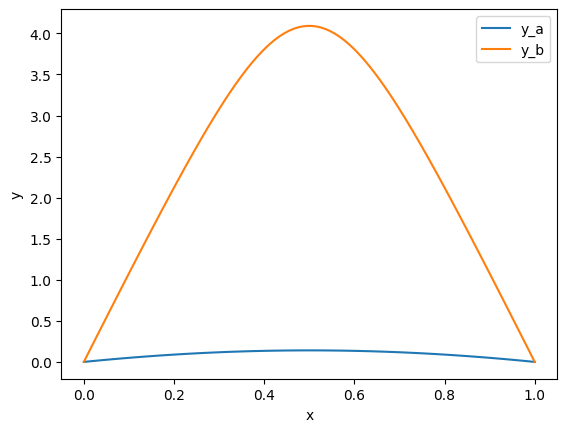

In [251]:
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp

def fun(x, y):
    print(np.vstack((y[1], -np.exp(y[0]))))
    return np.vstack((y[1], -np.exp(y[0])))

def bc(ya, yb):
    print('ya: '+ya.__repr__())
    print('yb: '+yb.__repr__())
    
    return np.array([ya[0], yb[0]])

x = np.linspace(0, 1, 5)

y_a = np.zeros((2, x.size))
y_b = np.zeros((2, x.size))
y_b[0] = 3

res_a = solve_bvp(fun, bc, x, y_a)
res_b = solve_bvp(fun, bc, x, y_b)

x_plot = np.linspace(0, 1, 100)
y_plot_a = res_a.sol(x_plot)[0]
y_plot_b = res_b.sol(x_plot)[0]

plt.plot(x_plot, y_plot_a, label='y_a')
plt.plot(x_plot, y_plot_b, label='y_b')
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [ ]:
def geodesic_equations(t, y):
    u, v, du_dt, dv_dt = y
    
    denominator = 1 - lambda_squared * np.sin(v)**2
    
    gamma_u_uu = 0
    gamma_u_vv = 0
    gamma_u_uv = 2 * e * cos(v) / denominator
    gamma_u_vu = gamma_u_uv
    
    gamma_v_uu = cos(v) * sin(v) / e
    gamma_v_vv = 0
    gamma_v_vu = - e * sin(v) / denominator
    gamma_v_uv = gamma_v_vu
    
    # Geodesic equations
    dudt = du_dt
    dvdt = dv_dt
    du2dt2 = -gamma_u_uu * du_dt**2 -\
              2 *  gamma_u_uv * du_dt * dv_dt -\
              gamma_u_vv * dv_dt**2
    
    dv2dt2 = -gamma_v_uu * du_dt**2 -\
          2 * gamma_v_uv * du_dt * dv_dt -\
              gamma_v_vv * dv_dt**2

    return [dudt, dvdt, du2dt2, dv2dt2]


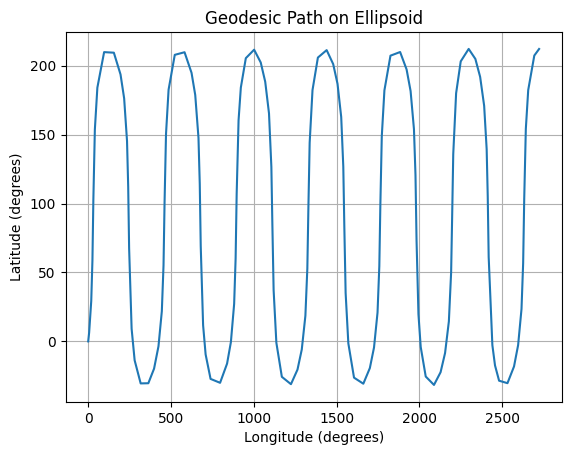

In [6]:
from numpy import sqrt, sin, cos, radians, degrees, sqrt
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Ellipsoid parameters
R = 6371.0    # Average radius of the Earth in kilometers
a = 6378.137  # Semi-major axis in kilometers
b = 6356.752  # Semi-minor axis in kilometers
lambda_squared = 1 - (b**2 / a**2)
e = sqrt(1 - lambda_squared)

# Geodesic equations
def great_ellipse_geodesic_equations(t, y):
    u, v, du_dt, dv_dt = y
    
    denominator = 1 - lambda_squared * np.sin(v)**2
    
    gamma_u_uu = 0
    gamma_u_vv = 0
    gamma_u_uv = 2 * e * cos(v) / denominator
    gamma_u_vu = gamma_u_uv
    
    gamma_v_uu = cos(v) * sin(v) / e
    gamma_v_vv = 0
    gamma_v_vu = - e * sin(v) / denominator
    gamma_v_uv = gamma_v_vu
    
    # Geodesic equations
    dudt = du_dt
    dvdt = dv_dt
    du2dt2 = -gamma_u_uu * du_dt**2 -\
              2 *  gamma_u_uv * du_dt * dv_dt -\
              gamma_u_vv * dv_dt**2
    
    dv2dt2 = -gamma_v_uu * du_dt**2 -\
          2 * gamma_v_uv * du_dt * dv_dt -\
              gamma_v_vv * dv_dt**2

    return [dudt, dvdt, du2dt2, dv2dt2]

# Initial conditions
u0 = 0.0       # Initial value for u
v0 = 0.0       # Initial value for v
du0_dt = 10.0  # Initial velocity for u
dv0_dt = 10.0  # Initial velocity for v

# Time span for integration
t_span = (0, 5)  # Adjust the time span as needed

y_initial=[u0, v0, du0_dt, dv0_dt]

# Solve the geodesic equations numerically
# TAKE NOTE: Adjust the maximum step size as needed
solution = solve_ivp(
    fun=lambda t, y: great_ellipse_geodesic_equations(t, y),
    t_span=t_span,
    y0=y_initial,
    method='RK45',
    max_step=1.0  
)

# Extract the results
u_values = solution.y[0]
v_values = solution.y[1]

# Convert back to latitude and longitude
latitude_values = degrees(v_values)
longitude_values = degrees(u_values)

# Plot the geodesic path on the ellipsoid
plt.plot(longitude_values, latitude_values)
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.title('Geodesic Path on Ellipsoid')
plt.grid(True)
plt.show()

In [2]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt

# Ellipsoid parameters
R = 6371.0  # Average radius of the Earth in kilometers
a = 6378.137  # Semi-major axis in kilometers
b = 6356.752  # Semi-minor axis in kilometers
lambda_squared = 1 - (b**2 / a**2)

# Geodesic equations
def geodesic_equations(u, v, du_dt, dv_dt):
    # Geodesic equations
    dudt = du_dt
    dvdt = dv_dt
    du2dt2 = -2 * np.sqrt(1 - lambda_squared) * np.cos(v) / (1 - lambda_squared * np.sin(v)**2) * du_dt * dv_dt
    dv2dt2 = -np.cos(v) * np.sin(v) / np.sqrt(1 - lambda_squared) * du_dt**2 + np.sqrt(1 - lambda_squared) * np.sin(v) / (1 - lambda_squared * np.sin(v)**2) * dv_dt * du_dt

    return np.vstack([dudt, dvdt, du2dt2, dv2dt2])

# Boundary conditions
def boundary_conditions(ya, yb):
    return np.array([ya[0], ya[1], yb[0], yb[1]])

# Initial and final values
u0 = 0.0
v0 = np.radians(45.0)
du0_dt = 1000.0
dv0_dt = 0.0
uf = 2.0
vf = np.radians(30.0)

# Solve the boundary value problem
solution = solve_bvp(
    fun=geodesic_equations,
    bc=boundary_conditions,
    x=np.linspace(u0, uf, 100),  # Adjust the number of points as needed
    y0=np.array([u0, v0, du0_dt, dv0_dt]),
    p=np.array([])  # No parameters in this case
)

# Extract the results
u_values = solution.x
v_values = solution.y[1]

# Convert back to latitude and longitude
latitude_values = np.degrees(v_values)
longitude_values = np.degrees(u_values)

# Plot the geodesic path on the ellipsoid
plt.plot(longitude_values, latitude_values)
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.title('Geodesic Path on Ellipsoid with Boundary Conditions')
plt.grid(True)
plt.show()

TypeError: solve_bvp() got an unexpected keyword argument 'y0'